## Assignment-7 : Sound localisation
- In this assignment , we will use Delay and Sum algorithm to detect obstacles.

### Necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Parameters

In [2]:
#Number of mics
Nmics = 64 
#Number of time samples needed
Nsamp = 200
#Position of source
src = (0, 0) 
# Spacing between microphones
pitch = 0.1
# Step to increase the samples in distance
dist_per_samp = 0.1
# Speed of sound in the medium
C = 2.0
# Time dilation factor for sinc pulse: how narrow
SincP = 5.0
#Array to store the location of mics
min_samps=Nsamp
#Maximum samples needed
mics = []

def mic_gen():
    global mics,Nmics,Nsamp
    mics=[]
    for i in range(Nmics):
        loc=(-(Nmics*pitch)/2)+(i*pitch)
        q=src[1]/pitch #To remove the mic location at the source
        if(i>=Nmics/2+q and q>-Nmics and q<Nmics and Nmics%2==0): loc+=pitch #Mic should not be placed at source so we are adding a pitch distance once we reach origin
        mics.append((0,loc))
    return(None)

mic_gen() #Generating mics

# Location of point obstacle
obstacle = (3, -1)

### Sinc function

In [3]:
def wsrc(t):
    return np.sinc(SincP*t)

### Realising impact of SincP in the wrsc() function

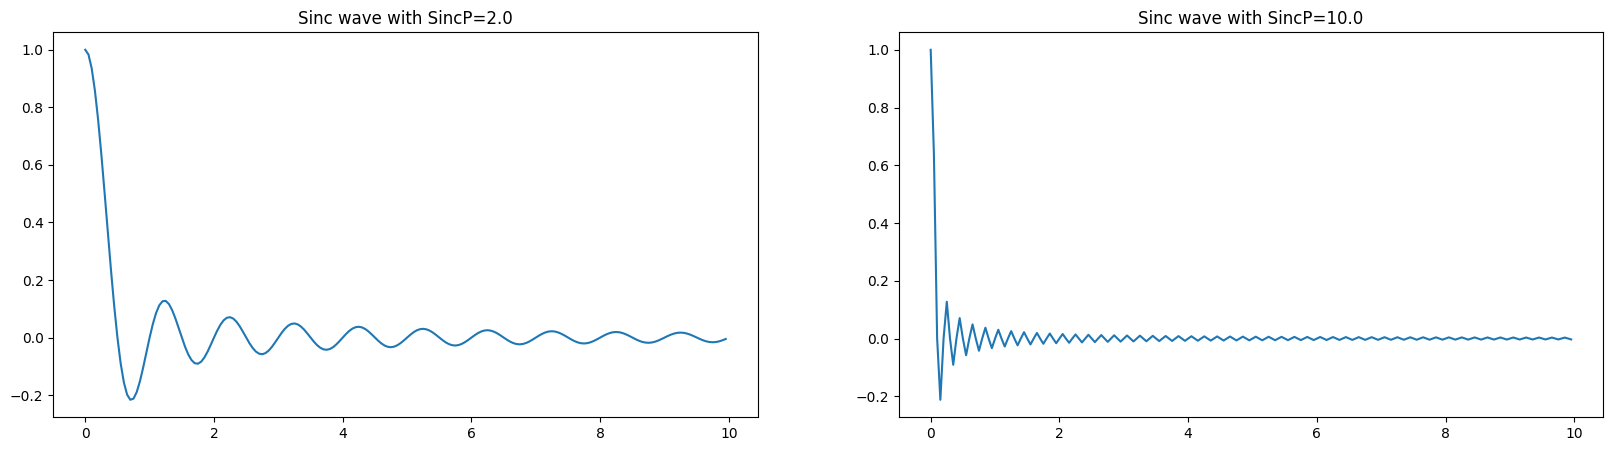

In [4]:
time=np.arange(0,Nsamp*dist_per_samp/C,dist_per_samp/C) #Array that contains various timestamps
SincP=2.0
samples_1=wsrc(time) #Function with SincP=2.0
SincP=10.0
samples_2=wsrc(time) #Function with SincP=10.0
fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].plot(time,samples_1)
ax[0].set_title("Sinc wave with SincP=2.0")
ax[1].plot(time,samples_2)
ax[1].set_title("Sinc wave with SincP=10.0")
plt.show()

- We can infer that increasing SincP parameter decreases the rate at which sinc function decays.
- So SincP is the parameter that affects the width between the samples.

### Function to evaluate the sum of distance between source,mic,given point

In [5]:
def dist(src, pt, mic):
    d1=((src[0]-pt[0])**2+(src[1]-pt[1])**2)**0.5 #Distance between source and given point
    d2=((mic[0]-pt[0])**2+(mic[1]-pt[1])**2)**0.5 #Distance between mic and given point
    return d1 + d2

### Function to return the data for the reflected wave by the obstacle

In [6]:
def sample_out():
    N,M=Nmics,Nsamp #Defining the dimensions of the data
    data=np.zeros((N,M))
    for i in range(N): 
        delay=(dist(src,obstacle,mics[i]))/C #Finding time delay for the wave to reach mic after reflection
        t_samp=dist_per_samp/C #Sampling rate of time
        time=np.arange(-delay,-delay+(M*t_samp),t_samp) #Array that stores all timestamps where the value will be evaluated
        data[i]=wsrc(time) #Finding the sinc value
    return(data)

### Function to display the reflected wave pattern

In [7]:
def display_ref(data):
    fig,ax=plt.subplots(1,2,figsize=(16, 6)) #Figure size of reflected pattern
    x = np.linspace(0, 10, Nsamp)  # X-axis values
    q=src[1]/pitch+Nmics//2 #To check at the source
    for i, row in enumerate(data):
        p=i #To change the pattern vertically
        if(i>=q-1 and q>0 and q<=Nmics): 
            p=i+1 #To leave space as at 0 there is no mic
        ax[0].plot(x, row - p, color='C{}'.format(i % 10)) 
    ax[0].set_ylabel("MIC")
    ax[0].set_xlabel("Samples")
    ax[0].set_title("Reflected wave at the mic array")

    org=np.zeros(Nsamp)
    if(q>0 and q<=Nmics): data_u=np.insert(data,int(q)-1,org,axis=0)
    am = ax[1].imshow(data_u, aspect='auto', cmap='viridis', origin='upper') #Plotting the heatmap
    ax[1].set_title("Heatmap of reflected wave")
    ax[1].set_xlabel("X-axis")
    ax[1].set_ylabel("Y-axis")
    fig.colorbar(am, orientation='vertical')
    plt.show()

    return(None)

- In the above code , I have explicitly made the mics not to coincide with the source.
- It is done by generating adding an another element just with zeros and displaying it on the axis

### Generating the data and displaying it

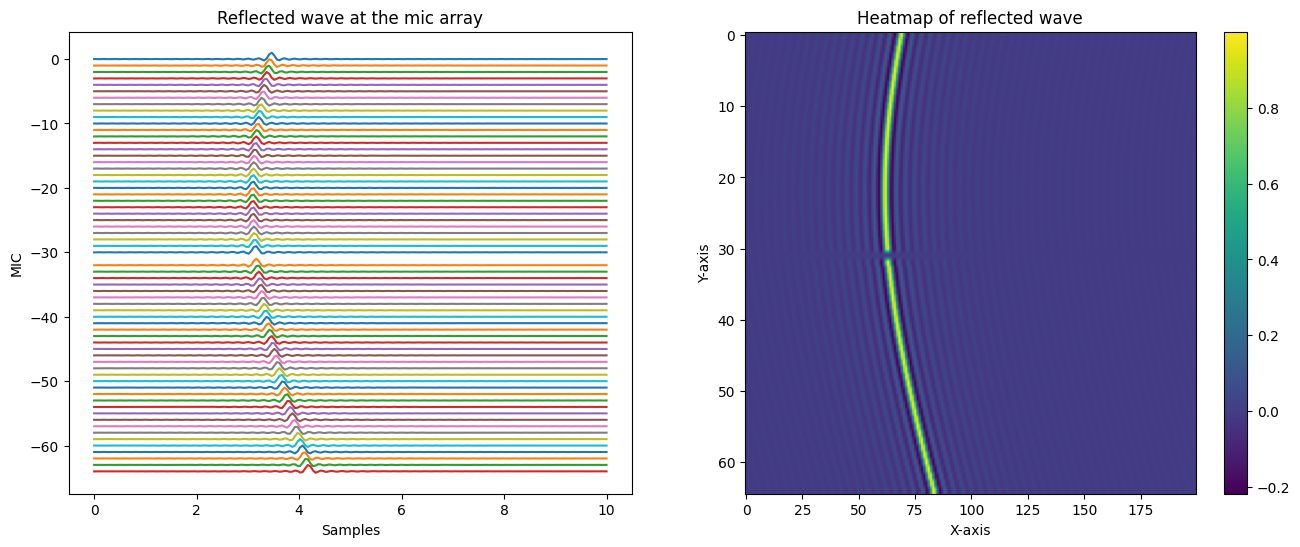

In [8]:
data_u=sample_out() #Data for the reflected wave at the time samples
display_ref(data_u) #Displaying it

### Function to generate the grid with obstacle on it
- It intakes the data array that has samples distributed at the time interval of dt at various mics

In [9]:
def das_imp(data):
    global min_samps
    rect=np.zeros((Nmics,Nsamp)) #Grids
    max_samp=0 # To find the minimmum position at which it delay goes out
    x = np.linspace(0, Nsamp*dist_per_samp/C, Nsamp) #The x-axis values - with the time interval of dist_per_samp/C
    for i in range(Nmics):
        _=Nsamp #Dummy variable to find the min at each mic position
        for j in range(Nsamp):
            pt=(x[j]*C,mics[i][1]) #The point at which we are measuring the delay
            for p,q in enumerate(mics): #Finding the sample for each mic
                dt=dist(src,pt,q) # Calculating distance
                pos=(dt//dist_per_samp) #Finding the position in the data_array
                if(pos<Nsamp):
                    rect[i][j]+=data[p][int(pos)]
                else:
                    _=min(_,j) #Finding the minimum value for which the data becomes 0
        max_samp = max(max_samp,_) #As we need to find the maximum among all the minimum position where each array becomes 0
    min_samps=max_samp
    return(rect)

### Function to display the reconstructed image

In [10]:
def disp(data,ax,str):
    val=(das_imp(data))
    am=ax.imshow(val, aspect='auto', cmap='viridis', origin='upper') #Plotting the heatmap
    ax.set_title(str)
    return(am)

### Displaying all the data given

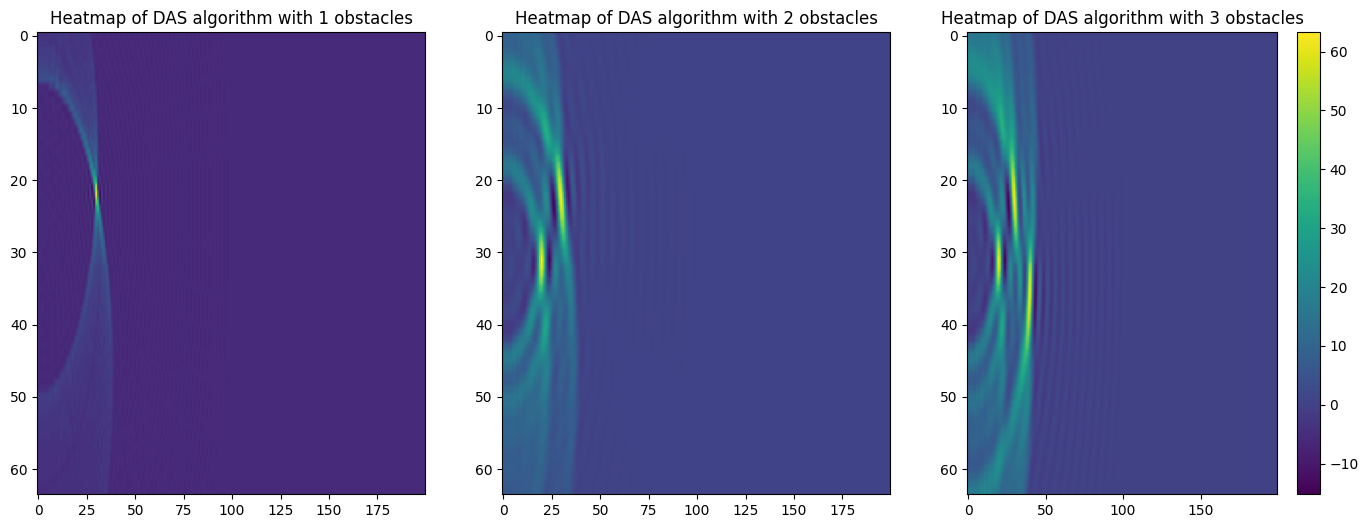

In [12]:
fig,ax=plt.subplots(1,3,figsize=(17,6))
data1=np.loadtxt("rx2.txt")
data2=np.loadtxt("rx3.txt")
datas=[data_u,data1,data2] #All graphs
am=0
for i in range(3):
    str=f"Heatmap of DAS algorithm with {i+1} obstacles"
    am=disp(datas[i],ax[i],str)
fig.colorbar(am, orientation='vertical')
plt.show()

### Minimum Nsamp required and changing C

The minimum Nsamp required is 97


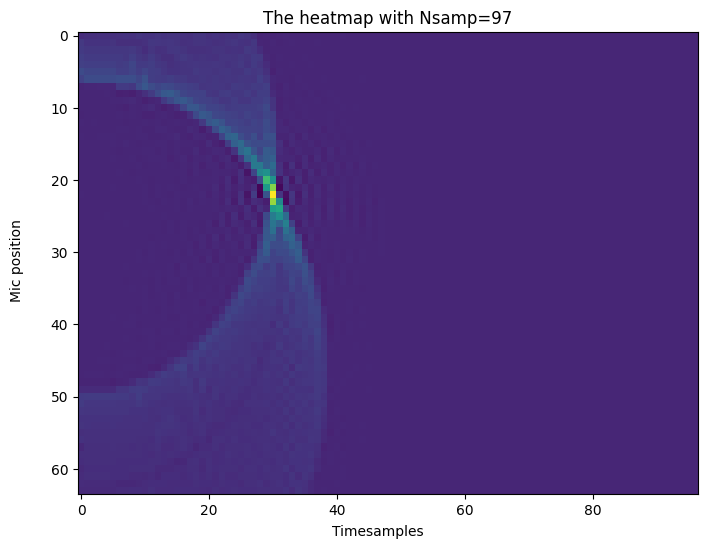

In [13]:
print(f"The minimum Nsamp required is {min_samps}")
Nsamp=min_samps #Changing the Nsamp to our found value
new_dat=sample_out()
fig,ax=plt.subplots(1,figsize=(8,6))
fig.text(0.5, 0.04, 'Timesamples', ha='center')
fig.text(0.04, 0.5, 'Mic position', va='center', rotation='vertical')
str=f"The heatmap with Nsamp={min_samps}"
am=disp(new_dat,ax,str)
plt.show()

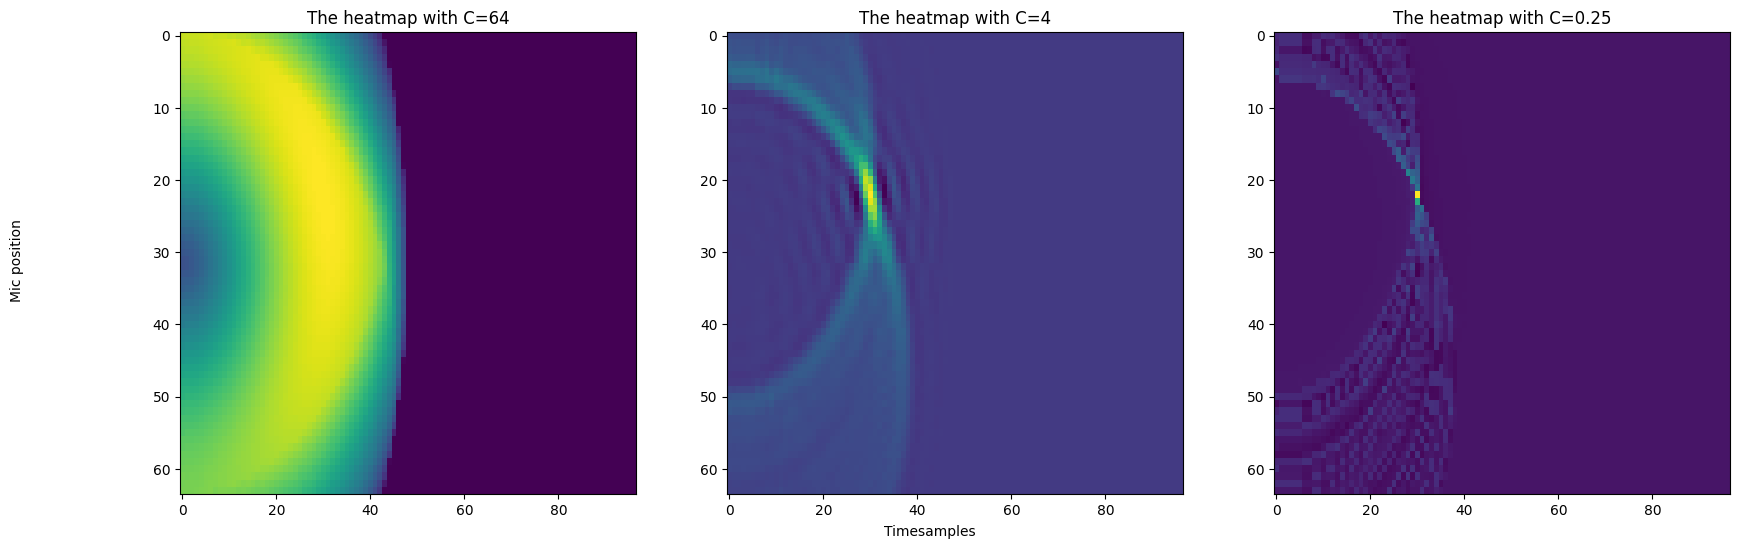

In [14]:
fig,ax=plt.subplots(1,3,figsize=(20,6))
fig.text(0.5, 0.04, 'Timesamples', ha='center')
fig.text(0.04, 0.5, 'Mic position', va='center', rotation='vertical')
c_val=[64,4,0.25]
for j,i in enumerate(c_val):
    C=i
    new_dat=sample_out()
    str=f"The heatmap with C={i}"
    am=disp(new_dat,ax[j],str)
plt.show()

### Tweaking around parameters

In [15]:
def test():
    global Nsamp,Nmics # To change the paramters in between the working
    fig,ax=plt.subplots(3,3,figsize=(11,10))
    fig.text(0.5, 0.04, 'Timesamples', ha='center')
    fig.text(0.04, 0.5, 'Mic position', va='center', rotation='vertical')
    test_mics=[8,32,64]
    test_samps=[50,100,200]
    for p,i in enumerate(test_mics):
        for q,j in enumerate(test_samps):
            Nsamp,Nmics=j,i
            mic_gen()
            new_data=sample_out()
            str=f"Nsamp = {j} and Nmics = {i}"
            disp(new_data,ax[p][q],str)
    return(None)

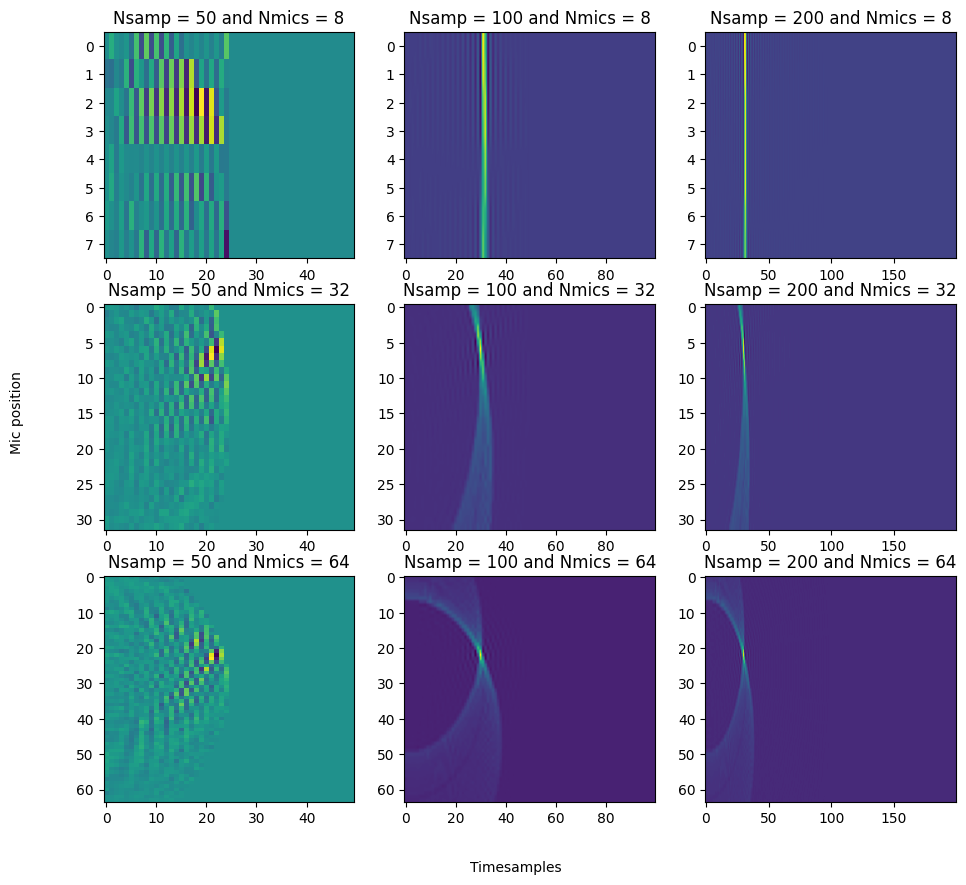

In [16]:
C=2
test()